<a href="https://colab.research.google.com/github/pathikg/Flower-Classification/blob/main/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   47G   32G  60% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        86G   51G   35G  60% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            79G   49G   30G  62% /content/drive


In [3]:
!nvidia-smi 

Fri Oct 15 15:27:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import pickle 
import random 
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

setting up main directory


In [5]:
os.chdir("/content/drive/MyDrive/Flower classification/")

## Dataset info

Dataset is available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1ECTVN

Our dataset contains 5 different types of flowers having 600-800 images for each type :
1. daisy
2. dandelion 
3. roses 
4. sunflowers
5. tulips

## Looking around the data

In [6]:
os.listdir("./flowers/flower_photos")

['.DS_Store', 'train', 'validation', 'test']

So we already have 3 different subsets for train, test and validation !

In [7]:
os.listdir("./flowers/flower_photos/train")

['sunflowers', 'roses', 'daisy', 'dandelion', 'tulips']

In [8]:
print("Number of images per flower type")
for class_name in os.listdir("./flowers/flower_photos/train"):
    class_path = os.path.join("./flowers/flower_photos/train", class_name)
    print(f"{class_name}:{len(os.listdir(class_path))}")

Number of images per flower type
sunflowers:673
roses:615
daisy:607
dandelion:872
tulips:773


### Just looking at one sample image

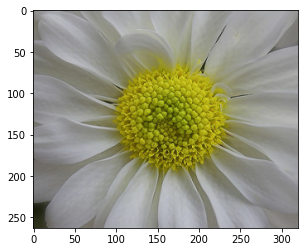

In [9]:
img = cv2.imread("./flowers/flower_photos/train/daisy/100080576_f52e8ee070_n.jpg", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [10]:
img.shape

(263, 320, 3)

## Let's load the data 

In [11]:
train_dir = "./flowers/flower_photos/train"
test_dir = "./flowers/flower_photos/test"
valid_dir = "./flowers/flower_photos/validation"
classes = os.listdir(train_dir) # store classes of flowers

In [12]:
def load_data(dir):
    X = []
    y = []
    for class_name in os.listdir(dir):
        class_id = classes.index(class_name)
        class_path = os.path.join(dir, class_name)
        for img_name in tqdm(os.listdir(class_path)) :
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            img = np.array(img)
            X.append(img)
            y.append(class_id)
    return np.array(X), np.array(y) 

In [18]:
X_train, y_train = load_data(train_dir)

100%|██████████| 773/773 [07:57<00:00,  1.62it/s]


In [16]:
X_valid, y_valid = load_data(valid_dir)

100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


In [17]:
X_test, y_test = load_data(test_dir)

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


In [19]:
X_train.shape

(3540, 224, 224, 3)

In [20]:
y_train.shape

(3540,)

### Converting target values to categories 

like if y1 = 0, y2 = 1, ...y5 = 4 
so our y1 will be [1,0,0,0,0],  y2 will be [0,1,0,0,0] , ...

In [21]:
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [22]:
y_train.shape

(3540, 5)

In [23]:
y_valid.shape

(80, 5)

### Shuffling data 

In [24]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test  = shuffle(X_test, y_test)

## Let's just visualize some flowers 
just to make sure everything is correct

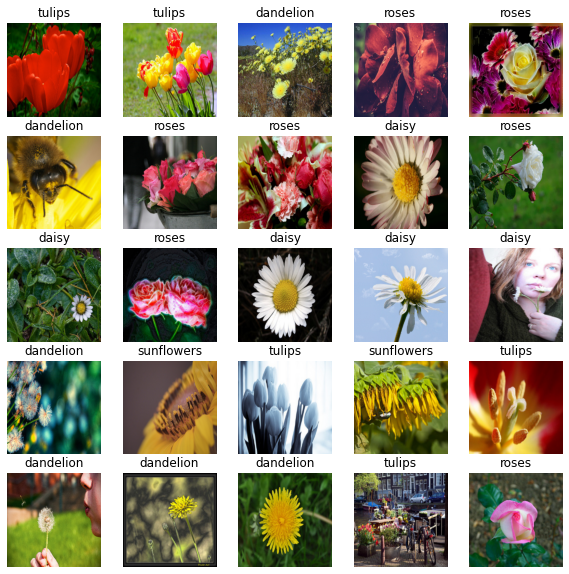

In [25]:
fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.flatten()

for ax in axes :
    i = np.random.randint(0,3000)
    img = X_train[i,:,:,:]
    label = classes[np.argmax(y_train[i,:])]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

## Model creation

In [38]:
def create_model() : 
    base_model = tf.keras.applications.vgg16.VGG16(
        input_shape = (224,224,3), include_top=False, weights='imagenet'
    )
    base_model.trainable = False
    model = Sequential(base_model, name="VGGNet")
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(len(classes) , activation="softmax"))
    return model

In [39]:
model = create_model()

58900480/58889256 [==============================] - 1s 0us/step


In [40]:
model.summary()

Model: "MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 21,156,165
Trainable params: 6,441,477
Non-trainable params: 14,714,688
_____________________________________

In [41]:
model.compile(
    optimizer="Adam", 
    loss="categorical_crossentropy",
    metrics = ["accuracy"]
)

In [42]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
111/111 [==============================] - 49s 344ms/step - loss: 33.7359 - accuracy: 0.7285 - val_loss: 7.2351 - val_accuracy: 0.8000
Epoch 2/10
111/111 [==============================] - 26s 236ms/step - loss: 2.1764 - accuracy: 0.9234 - val_loss: 4.7156 - val_accuracy: 0.8625
Epoch 3/10
111/111 [==============================] - 26s 237ms/step - loss: 0.9144 - accuracy: 0.9568 - val_loss: 5.3465 - val_accuracy: 0.9000
Epoch 4/10
111/111 [==============================] - 26s 238ms/step - loss: 0.5968 - accuracy: 0.9754 - val_loss: 6.8974 - val_accuracy: 0.8375
Epoch 5/10
111/111 [==============================] - 26s 239ms/step - loss: 1.0717 - accuracy: 0.9655 - val_loss: 5.8294 - val_accuracy: 0.8250
Epoch 6/10
111/111 [==============================] - 26s 238ms/step - loss: 0.9760 - accuracy: 0.9655 - val_loss: 13.1069 - val_accuracy: 0.8250
Epoch 7/10
111/111 [==============================] - 26s 236ms/step - loss: 1.3352 - accuracy: 0.9692 - val_loss: 13.5985 - val

In [43]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 6s 6s/step - loss: 22.9858 - accuracy: 0.8400


[22.985841751098633, 0.8399999737739563]

In [37]:
model.save("model.h5")